In [1]:
from proba_contextfg import get_all_trees, build_pcfg
from utils import read_file, write_file, compute_precision
from sklearn.model_selection import train_test_split
from out_of_vocab import OOV_module
from proba_cyk import PCKY
import numpy as np
from nltk import Tree
import warnings
warnings.simplefilter('ignore')

mode = 'test' #mode = 'eval' pour l'évaluation avec de nouvelles phrases
path_grammar = 'sequoia-corpus+fct.mrg_strict'
path_embeddings = 'polyglot-fr.pkl'
grammars = read_file(path_grammar)
grammars_train, grammars_test = train_test_split(grammars, test_size=0.1, shuffle=False) 
tree_cfg_grammars = get_all_trees(grammars_train)
corpus = [' '.join(tree.leaves()) for tree in tree_cfg_grammars]
axiomes, lexicons, dico_lexicons, dico_cfg = build_pcfg(tree_cfg_grammars)
## Construction d'un modèle CYK
oov = OOV_module(path_embeddings = path_embeddings, 
                 lexicons=lexicons, corpus = corpus)
## Construction des dictionnaires contenant 
## les probabilités associés au unigrams et bigrams du Corpus
oov.build_unigram_bigram()
## Probabilistc CKY
pcky = PCKY(oov=oov, dico_lexicons=dico_lexicons,
            dico_cfg=dico_cfg, axiomes=axiomes, 
            lexicons=lexicons)

In [2]:
## precision/score en fonction de la taille de la phrase
import pandas as pd
def get_df(corpus, predictions_train, status, grammars_train):
    df = pd.DataFrame([len(sent.split()) for sent in corpus], columns =['taille'])
    df['nb moyen succes'] = status
    df['precision moyenne'] = [compute_precision([predictions_train[i]], 
                          [grammars_train[i]]) for i in range(len(corpus))]
    df['nb OOV'] = [len([elt for elt in sent.split() if elt.lower() not in lexicons]) for sent in corpus]
    return df

In [8]:
predictions_train = [pcky.induce_CYK(sentence, show=True) for sentence in corpus[:300]]
status, predictions_train_ = [x[1] for x in predictions_train], [x[0] for x in predictions_train]

In [9]:
print('Precision on test with all :', compute_precision(predictions_train, grammars_train[:300]))
print('Precision on test with success only', compute_precision(predictions_train, grammars_train[:300])* len(grammars_train[:300])/sum(status))

Precision on test with all : 0.8407724399755201
Precision on test with success only 0.8407724399755201


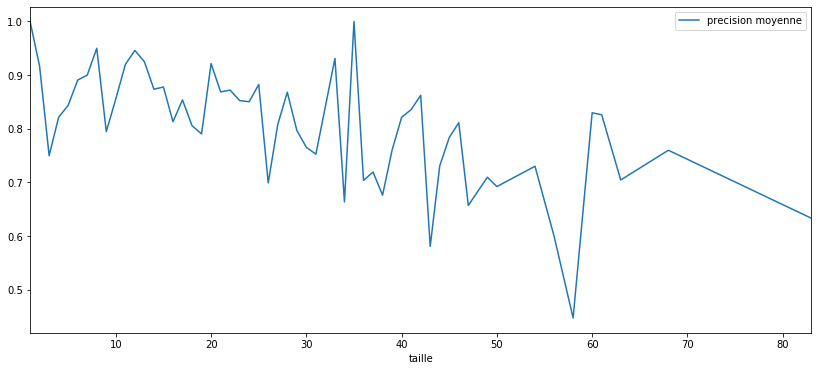

In [10]:
df_tmp = get_df(corpus[:300], predictions_train, status, grammars_train[:300])
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize = (14, 6))
df_tmp.groupby('taille').mean().reset_index().plot(x="taille", 
                                               y=["precision moyenne"], kind='line', ax = ax);

In [3]:
cfg_test = get_all_trees(grammars_test)
corpus_test = [' '.join(tree.leaves()) for tree in cfg_test]
from multiprocessing import Pool
def return_result(sent):
    return pcky.induce_CYK(sent, show=False)
with Pool(8) as p: 
    predictions_test = p.map(return_result, corpus_test)

In [4]:
status_test, predictions_test_ = [x[1] for x in predictions_test], [x[0] for x in predictions_test]

In [12]:
320-sum(status_test)

117

In [6]:
print('Precision on test with all :', compute_precision(predictions_test, grammars_test))
print('Precision on test with success only', compute_precision(predictions_test, grammars_test)* len(grammars_test)/sum(status_test))

Precision on test with all : 0.4234921737237196
Precision on test with success only 0.6467121864746457


In [7]:
df = get_df(corpus_test, predictions_test, status_test, grammars_test)

In [8]:
df.groupby('nb moyen succes').mean()

,taille,precision moyenne,nb OOV
nb moyen succes,,,
0,25.000000,0.000000,4.700935
1,18.551724,0.646712,2.463054


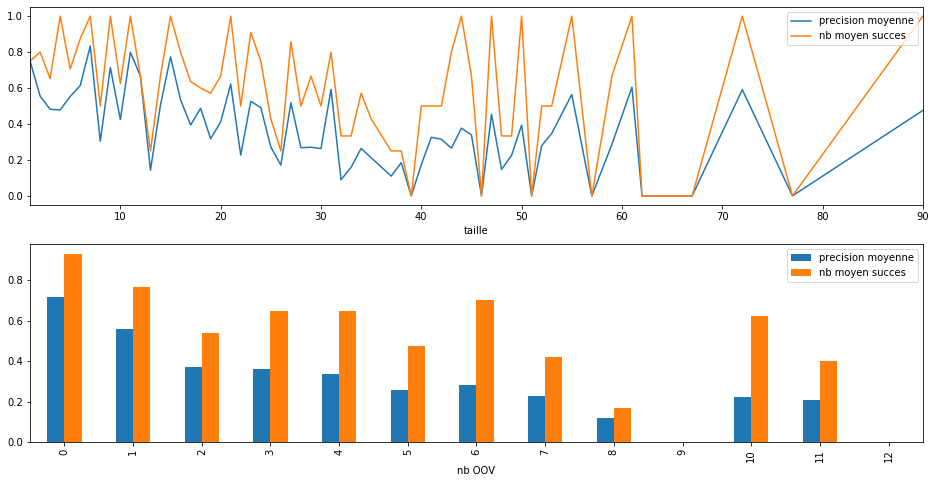

In [10]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2, 1, figsize = (16, 8))
df.groupby('taille').mean().reset_index().plot(x="taille", 
                                               y=["precision moyenne", "nb moyen succes"], 
                                               kind='line', ax = ax[0]);
df.groupby('nb OOV').mean().reset_index().plot(x="nb OOV", 
                                              y=["precision moyenne", "nb moyen succes"],
                                              kind='bar', ax = ax[1]);
plt.savefig('evaluation.png')

In [11]:
write_file(predictions_test_, corpus_test)

The prediction on the test will be written here :  evaluation_data.parser_output
The corresponding ground sentences will be written : test_sentences.txt
